# Enhancing E-Commerce Strategies Through Customer Behavior Analysis
<span style="font-size:20px;"> - Amisha Kelkar, Arundhati (Ari) Kolahal, Chaitali Deshmukh, Neha Shastri

## Product Recommendation using NLP


### Importing Relevant Libraries

In [ ]:
pip install sentence_transformers
pip install wordcloud
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import json
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re
from datetime import datetime
import pyarrow.feather as feather

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Loading the Dataset

In [ ]:
df = pd.read_parquet('product_recommendation.parquet')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   parent_asin          100 non-null    object
 1   product_title        100 non-null    object
 2   product_description  100 non-null    object
 3   product_reviews      100 non-null    object
 4   review_timestamps    100 non-null    object
dtypes: object(5)
memory usage: 4.0+ KB


### Product Recommendation
* Using NLP techniques for product recommendation.

In [ ]:
df['product_description']

0     GE MWF Refrigerator Water Filter | Certified t...
1     Keurig My K-Cup Reusable Coffee Filter - Old M...
2     Whirlpool 4396841 PUR [Fast Fill] FILTER3 Refr...
3     SAMSUNG Heating Element Dc47-00019A ["This hig...
4     Frigidaire ULTRAWF PureSource Ultra Water and ...
                            ...                        
95    EcoAqua EFF-6027A Replacement Filter, Compatib...
96    Stove Gap Covers Kitchen Counter Gap Covers (2...
97    Pureline DA29-00020B, Replacement for Samsung ...
98    Hamilton Beach Permanent Gold Tone Filter, Fit...
99    hOmeLabs Chill Pill Countertop Ice Maker - Per...
Name: product_description, Length: 100, dtype: object

In [ ]:
def convert_timestamps(ts_list):
    return [pd.to_datetime(ts) for ts in ts_list]

df['review_timestamps'] = df['review_timestamps'].apply(convert_timestamps)

* Initializing the deep-learning model `Sentence Transformer` to tokenize and vectorize the `product_descriptio` column.

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')

* Cleaning the `product_description` column by lower casing, striping blank spaces and removing special characters

In [ ]:
# Sample cleaning function
def clean_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    text = text.lower().strip()  # Convert to lowercase and strip spaces
    return text

def safe_convert(text):
    try:
        return ast.literal_eval(text) if isinstance(text, str) else text
    except (ValueError, SyntaxError):
        return []  # Return empty list if conversion fails

df['product_reviews'] = df['product_reviews'].apply(safe_convert)

# Ensure all elements are strings and apply text cleaning
df['product_reviews'] = df['product_reviews'].apply(lambda x: [clean_text(str(review)) for review in x if isinstance(review, str)])
df['product_description'] = df['product_description'].apply(lambda x : [clean_text(str(x))])


In [ ]:
df['product_reviews']

0     [although it was recommended for my refrigerat...
1     [works but this item works but if you like a f...
2     [genuine whirlpool filter works as designed, p...
3     [great value and it does the job bought it arr...
4     [excellent filter for frigidaire refrigerator ...
                            ...                        
95    [my 4th order in 5 years my first order of the...
96    [easy and fast got it fast exactly what was or...
97    [slow water i bought these last year and just ...
98    [definitely i wouldnt buy it again this produc...
99    [do not buy horrible support defective product...
Name: product_reviews, Length: 100, dtype: object

* Got the embeddings from the Sentence Transformer initated.
* Aggregated the embeddings for products based on the recency in order to ensure more weightage to the most recent reviews.

In [ ]:
# Function to get embeddings
def get_review_embedding(review):
    return model.encode(review) if review else np.zeros(model.get_sentence_embedding_dimension())

# Function to aggregate reviews with recency-based weighting
def aggregate_reviews(review_list, timestamp_list, lambda_decay=0.05):
    if not review_list or not timestamp_list:
        return np.zeros(model.get_sentence_embedding_dimension())  # Handle empty cases

    # Compute embeddings for each review
    review_embeddings = np.array([get_review_embedding(r) for r in review_list])

    # Find the most recent timestamp
    t_max = max(timestamp_list)

    # Compute recency weights: weight = exp(-lambda * days_diff)
    weights = np.array([np.exp(-lambda_decay * (t_max - t).days) for t in timestamp_list])
    weights = weights / weights.sum() if weights.sum() != 0 else weights  # Normalize weights

    # Return weighted average of embeddings
    return np.average(review_embeddings, axis=0, weights=weights)

# Compute aggregated review embedding for each product
df['aggregated_review_embedding'] = df.apply(
    lambda row: aggregate_reviews(row['product_reviews'], row['review_timestamps']), axis=1
)


In [ ]:
df['product_description']

0     [ge mwf refrigerator water filter  certified t...
1     [keurig my kcup reusable coffee filter  old mo...
2     [whirlpool 4396841 pur fast fill filter3 refri...
3     [samsung heating element dc4700019a this high ...
4     [frigidaire ultrawf puresource ultra water and...
                            ...                        
95    [ecoaqua eff6027a replacement filter compatibl...
96    [stove gap covers kitchen counter gap covers 2...
97    [pureline da2900020b replacement for samsung d...
98    [hamilton beach permanent gold tone filter fit...
99    [homelabs chill pill countertop ice maker  per...
Name: product_description, Length: 100, dtype: object

In [ ]:
df['feature_embedding'] = df['product_description'].apply(lambda x: model.encode(' '.join(x)))

* Combined the agregated embeddings and feature embeddings.

In [ ]:
def combine_embeddings(review_emb, feature_emb, review_weight=0.6, feature_weight=0.4):
    return (review_weight * review_emb) + (feature_weight * feature_emb)

df['final_product_embedding'] = df.apply(
    lambda row: combine_embeddings(row['aggregated_review_embedding'], row['feature_embedding']),
    axis=1
)

In [ ]:
# Check the length of each embedding in 'final_product_embedding'
embedding_lengths = df['final_product_embedding'].apply(lambda x: len(x) if isinstance(x, (list, np.ndarray)) else None)

# Show the unique lengths of embeddings
print("Unique lengths of embeddings:", embedding_lengths.unique())

Unique lengths of embeddings: [384]


* Converted the arrays to list and then saved it as a Dataframe using PyArrow

In [ ]:
# Convert NumPy arrays to list (if they are not already 1D)
df['aggregated_review_embedding'] = df['aggregated_review_embedding'].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)
df['feature_embedding'] = df['feature_embedding'].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)
df['final_product_embedding'] = df['final_product_embedding'].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

# Save the DataFrame as Feather
feather.write_feather(df, 'product_embedding.feather')



* Got product recommendations based on an input query stating the requirement of the product, for example 'washing machine' here.

In [ ]:
df = pd.read_feather('product_embedding.feather')
model = SentenceTransformer('all-MiniLM-L6-v2')
# Define the query and its embedding
query = "washing machine"
query_embedding = model.encode(query)

df['final_product_embedding'] = df['final_product_embedding'].apply(lambda x: np.array(x) if isinstance(x, list) else x)

# Calculate similarity between the query and each product's embedding
df['similarity'] = df['final_product_embedding'].apply(
    lambda emb: cosine_similarity([query_embedding], [emb])[0][0]
)


* Top 10 recommendations for the query using cosine similarity

In [ ]:
print("Product Recommendations:")
# Sort by similarity and get the top 10 recommendations
df_sorted = df[['parent_asin', 'product_title', 'similarity', 'product_description']].sort_values(by='similarity', ascending=False).head(10)
df_sorted

Product Recommendations:


,parent_asin,product_title,similarity,product_description
83,B0BWBF4MN1,WonderWash Portable Washing Machine for Apartm...,0.682301,[wonderwash portable washing machine for apart...
16,B01ALBMIEI,Giantex Portable Mini Compact Twin Tub Washing...,0.671518,[giantex portable mini compact twin tub washin...
29,B07B94ZR74,SUPER DEAL Compact Mini Twin Tub Washing Machi...,0.666655,[super deal compact mini twin tub washing mach...
62,B09W5PMK5X,COMFEE’ Washing Machine 2.4 Cu.ft LED Portable...,0.665828,[comfee washing machine 24 cuft led portable w...
45,B081K4Q6KQ,Cimkiz Dishwasher Magnet Clean Dirty Sign Shut...,0.405758,[cimkiz dishwasher magnet clean dirty sign shu...
47,B085R91V61,Rustic Farmhouse Dishwasher Magnet Clean Dirty...,0.402034,[rustic farmhouse dishwasher magnet clean dirt...
70,B0BBYGZMTT,"Dishwasher Magnet Clean Dirty Sign, Universal ...",0.391879,[dishwasher magnet clean dirty sign universal ...
20,B01KHITHE4,"OUGAR8 Refrigerator Door Handle Covers,Keep Yo...",0.384513,[ougar8 refrigerator door handle coverskeep yo...
25,B074WCLFPV,"SPT Countertop Dishwasher, White",0.376466,[spt countertop dishwasher white perfect for a...
77,B0BS6H2WL5,"EUHOMY Ice Maker Machine Countertop, 26 lbs in...",0.295891,[euhomy ice maker machine countertop 26 lbs in...


In [ ]:
df_unique_titles = pd.DataFrame(df_sorted['product_title'].unique(), columns=['product_title'])
df_unique_titles.head(50)

,product_title
0,WonderWash Portable Washing Machine for Apartm...
1,Giantex Portable Mini Compact Twin Tub Washing...
2,SUPER DEAL Compact Mini Twin Tub Washing Machi...
3,COMFEE’ Washing Machine 2.4 Cu.ft LED Portable...
4,Cimkiz Dishwasher Magnet Clean Dirty Sign Shut...
5,Rustic Farmhouse Dishwasher Magnet Clean Dirty...
6,"Dishwasher Magnet Clean Dirty Sign, Universal ..."
7,"OUGAR8 Refrigerator Door Handle Covers,Keep Yo..."
8,"SPT Countertop Dishwasher, White"
9,"EUHOMY Ice Maker Machine Countertop, 26 lbs in..."


* For a sense of most frequent words on the `product_title`, a wordcloud was generated.

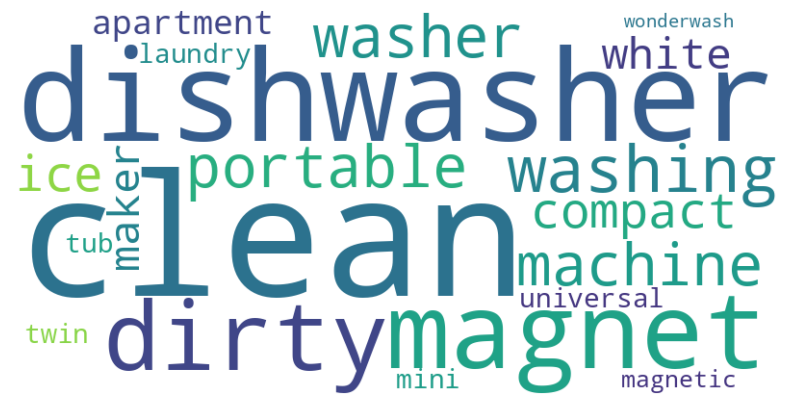

In [ ]:
# Assuming df_unique_titles is the DataFrame with unique product titles
def preprocess_text(text):
    # Remove special characters and stop words
    words = [word for word in text.lower().split() if word not in ENGLISH_STOP_WORDS and word.isalpha()]
    return " ".join(words)

df_unique_titles['processed_title'] = df_unique_titles['product_title'].apply(preprocess_text)

# Generate the word cloud with a limit on the top 20 words
text = " ".join(df_unique_titles['processed_title'])
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=20).generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Don't show axes
plt.show()
